In [1]:
# import here
import PIL
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torch.utils.data.sampler as sampler
from torch import nn, optim
import torch.nn.functional as F
%matplotlib inline

---
# Load The Data

In [2]:
# Load pickled data
training_file = "data/train.p"
validation_file = "data/valid.p"
testing_file = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

# Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

In [3]:
# Number of training examples
n_train = len(X_train)
# Number of validation examples.
n_valid = len(X_valid)
# Number of testing examples.
n_test = len(X_test)

# The shape of an traffic sign image
image_shape = X_train[0].shape[:-1]

# Number of unique classes/labels in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


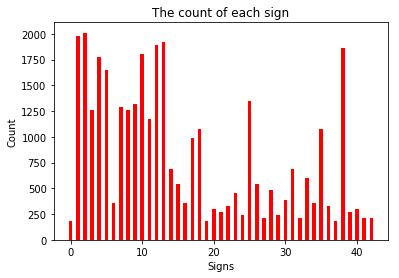

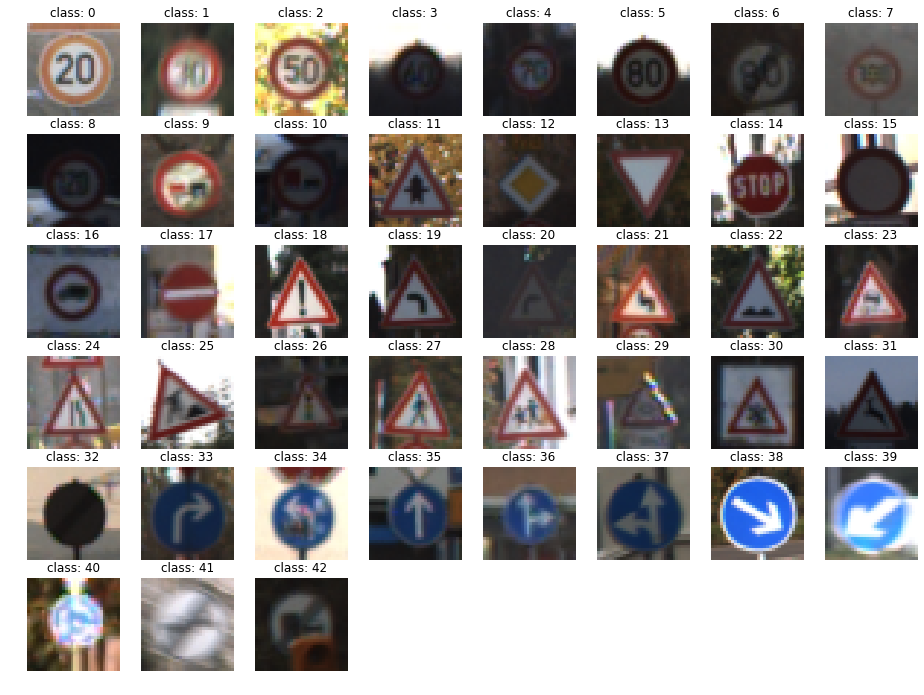

In [4]:
### Data exploration visualization.
fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(y_train), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(X_train[i])

----

# Design and Test a Baseline Model Architecture

## Custom Dataset & DataLoader

In [6]:
class PickledDataset(Dataset):
    def __init__(self, file_path, transform=None):
        with open(file_path, mode='rb') as f:
            data = pickle.load(f)
            self.features = data['features']
            self.labels = data['labels']
            self.count = len(self.labels)
            self.transform = transform
        
    def __getitem__(self, index):
        feature = self.features[index]
        if self.transform is not None:
            feature = self.transform(feature)
        return (feature, self.labels[index])

    def __len__(self):
        return self.count

In [7]:
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

## Baseline Model

In [8]:
class BaselineNet(nn.Module):
    def __init__(self, gray=False):
        super(BaselineNet, self).__init__()
        input_chan = 1 if gray else 3
        self.conv1 = nn.Conv2d(input_chan, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 43)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Training

In [9]:
torch.manual_seed(1)

In [10]:
train_dataset = PickledDataset(training_file, transform=transforms.ToTensor())
valid_dataset = PickledDataset(validation_file, transform=transforms.ToTensor())
test_dataset = PickledDataset(testing_file, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def preprocess(x, y):
    return x.to(device), y.to(device, dtype=torch.int64)

train_loader = WrappedDataLoader(train_loader, preprocess)
valid_loader = WrappedDataLoader(valid_loader, preprocess)
test_loader = WrappedDataLoader(test_loader, preprocess)

In [12]:
model = BaselineNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
n_epochs = 20

In [13]:
def loss_batch(model, loss_func, x, y, opt=None):
    loss = loss_func(model(x), y)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(x)

In [14]:
def valid_batch(model, loss_func, x, y):
    output = model(x)
    loss = loss_func(output, y)
    pred = torch.argmax(output, dim=1)
    correct = pred == y.view(*pred.shape)
    
    return loss.item(), torch.sum(correct).item(), len(x)

In [15]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        # Train model
        model.train()
        losses, nums = zip(*[loss_batch(model, loss_func, x, y, opt) for x, y in train_dl])
        train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        # Validation model
        model.eval()
        with torch.no_grad():
            losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in valid_dl])
            valid_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            valid_accuracy = np.sum(corrects) / np.sum(nums) * 100
            print(f"[Epoch {epoch+1}/{epochs}] "
                  f"Train loss: {train_loss:.6f}\t"
                  f"Validation loss: {valid_loss:.6f}\t",
                  f"Validation accruacy: {valid_accuracy:.3f}%")

In [16]:
def evaluate(model, loss_func, dl):
    model.eval()
    with torch.no_grad():
        losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in dl])
        test_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        test_accuracy = np.sum(corrects) / np.sum(nums) * 100
        
    print(f"Test loss: {test_loss:.6f}\t"
          f"Test accruacy: {test_accuracy:.3f}%")

In [17]:
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

[Epoch 1/20] Train loss: 3.675411	Validation loss: 3.591648	 Validation accruacy: 5.624%
[Epoch 2/20] Train loss: 3.484716	Validation loss: 3.570442	 Validation accruacy: 5.918%
[Epoch 3/20] Train loss: 3.457435	Validation loss: 3.540351	 Validation accruacy: 6.463%
[Epoch 4/20] Train loss: 3.339136	Validation loss: 3.346383	 Validation accruacy: 17.211%
[Epoch 5/20] Train loss: 2.706622	Validation loss: 2.366648	 Validation accruacy: 37.324%
[Epoch 6/20] Train loss: 1.715163	Validation loss: 1.630018	 Validation accruacy: 53.719%
[Epoch 7/20] Train loss: 1.146221	Validation loss: 1.169266	 Validation accruacy: 66.757%
[Epoch 8/20] Train loss: 0.856820	Validation loss: 0.973085	 Validation accruacy: 72.630%
[Epoch 9/20] Train loss: 0.679270	Validation loss: 0.972262	 Validation accruacy: 72.268%
[Epoch 10/20] Train loss: 0.562646	Validation loss: 0.821301	 Validation accruacy: 77.438%
[Epoch 11/20] Train loss: 0.477212	Validation loss: 0.721668	 Validation accruacy: 80.204%
[Epoch 12/2

---
# Experiment and find tuning

## Data preprocessing

In [18]:
class CLAHE_GRAY:
    def __init__(self, clipLimit=2.5, tileGridSize=(4, 4)):
        self.clipLimit = clipLimit
        self.tileGridSize = tileGridSize

    def __call__(self, im):
        img_y = cv2.cvtColor(im, cv2.COLOR_RGB2YCrCb)[:,:,0]
        clahe = cv2.createCLAHE(clipLimit=self.clipLimit, tileGridSize=self.tileGridSize)
        img_y = clahe.apply(img_y)
        img_output = img_y.reshape(img_y.shape + (1,))
        return img_output

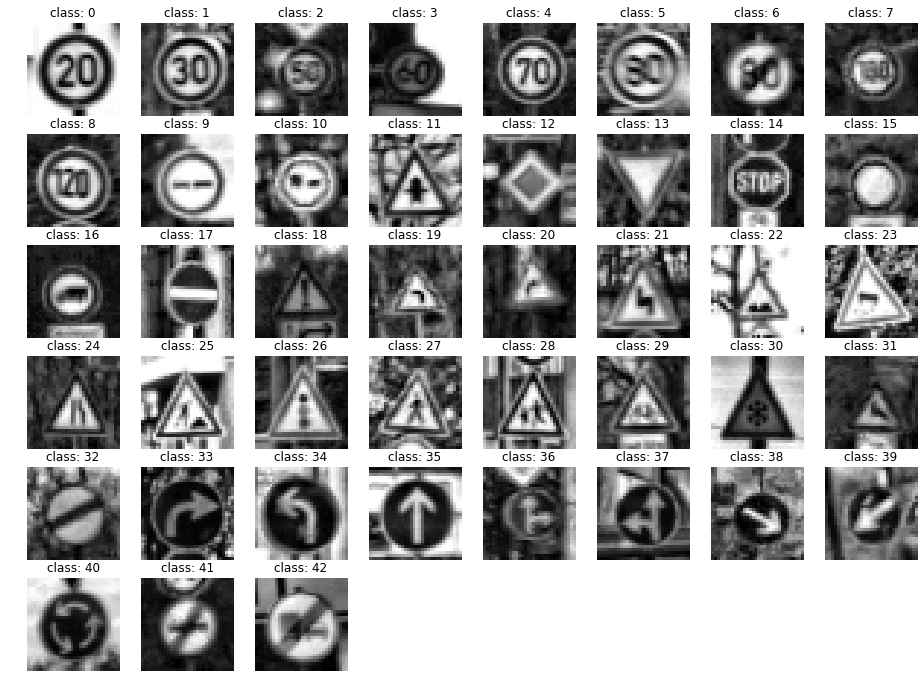

In [19]:
clahe = CLAHE_GRAY()
plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(clahe(X_train[i]).squeeze(), cmap='gray')

In [37]:
data_transforms = transforms.Compose([
    CLAHE_GRAY(),
    transforms.ToTensor()
])

train_dataset = PickledDataset(training_file, transform=data_transforms)
valid_dataset = PickledDataset(validation_file, transform=data_transforms)
test_dataset = PickledDataset(testing_file, transform=data_transforms)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), preprocess)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), preprocess)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), preprocess)

In [92]:
model = BaselineNet(gray=True).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

[Epoch 1/20] Train loss: 3.714800	Validation loss: 3.685895	 Validation accruacy: 4.762%
[Epoch 2/20] Train loss: 3.590278	Validation loss: 3.565225	 Validation accruacy: 5.442%
[Epoch 3/20] Train loss: 3.474012	Validation loss: 3.548073	 Validation accruacy: 9.433%
[Epoch 4/20] Train loss: 3.451042	Validation loss: 3.509039	 Validation accruacy: 11.678%
[Epoch 5/20] Train loss: 3.262759	Validation loss: 2.938886	 Validation accruacy: 25.601%
[Epoch 6/20] Train loss: 2.108421	Validation loss: 1.563424	 Validation accruacy: 51.156%
[Epoch 7/20] Train loss: 1.174533	Validation loss: 1.029016	 Validation accruacy: 71.723%
[Epoch 8/20] Train loss: 0.814401	Validation loss: 0.769131	 Validation accruacy: 78.798%
[Epoch 9/20] Train loss: 0.646002	Validation loss: 0.646135	 Validation accruacy: 81.633%
[Epoch 10/20] Train loss: 0.526677	Validation loss: 0.589391	 Validation accruacy: 83.515%
[Epoch 11/20] Train loss: 0.437621	Validation loss: 0.549396	 Validation accruacy: 84.059%
[Epoch 12/2

## Handling imbalanced dataset

### Flipping

In [32]:
def extend_dataset(dataset):
    X = dataset.features
    y = dataset.labels
    num_classes = 43
    
    X_extended = np.empty([0] + list(dataset.features.shape)[1:], dtype=dataset.features.dtype)
    y_extended = np.empty([0], dtype = dataset.labels.dtype)
    
    horizontally_flippable = [11, 12, 13, 15, 17, 18, 22, 26, 30, 35]
    vertically_flippable = [1, 5, 12, 15, 17]
    both_flippable = [32, 40]
    cross_flippable = np.array([
        [19, 20],
        [33, 34],
        [36, 37],
        [38, 39],
        [20, 19],
        [34, 33],
        [37, 36],
        [39, 38]
    ])
    
    for c in range(num_classes):
        X_extended = np.append(X_extended, X[y==c], axis=0)  
        
        if c in horizontally_flippable:
            X_extended = np.append(X_extended, X[y==c][:,:,::-1,:], axis=0)
        if c in vertically_flippable:
            X_extended = np.append(X_extended, X[y==c][:,::-1,:,:], axis=0)
        if c in cross_flippable[:,0]:
            flip_c = cross_flippable[cross_flippable[:,0]==c][0][1]
            X_extended = np.append(X_extended, X[y==flip_c][:,:,::-1,:], axis=0)
        if c in both_flippable:
            X_extended = np.append(X_extended, X[y==c][:,::-1,::-1,:], axis=0)
        
        y_extended = np.append(y_extended, np.full(X_extended.shape[0]-y_extended.shape[0], c, dtype=y_extended.dtype))
    
    dataset.features = X_extended
    dataset.labels = y_extended
    dataset.count = len(y_extended)
    
    return dataset

In [41]:
train_dataset = extend_dataset(train_dataset)
train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), preprocess)

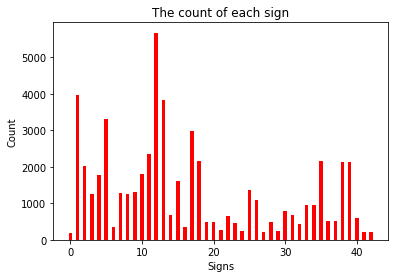

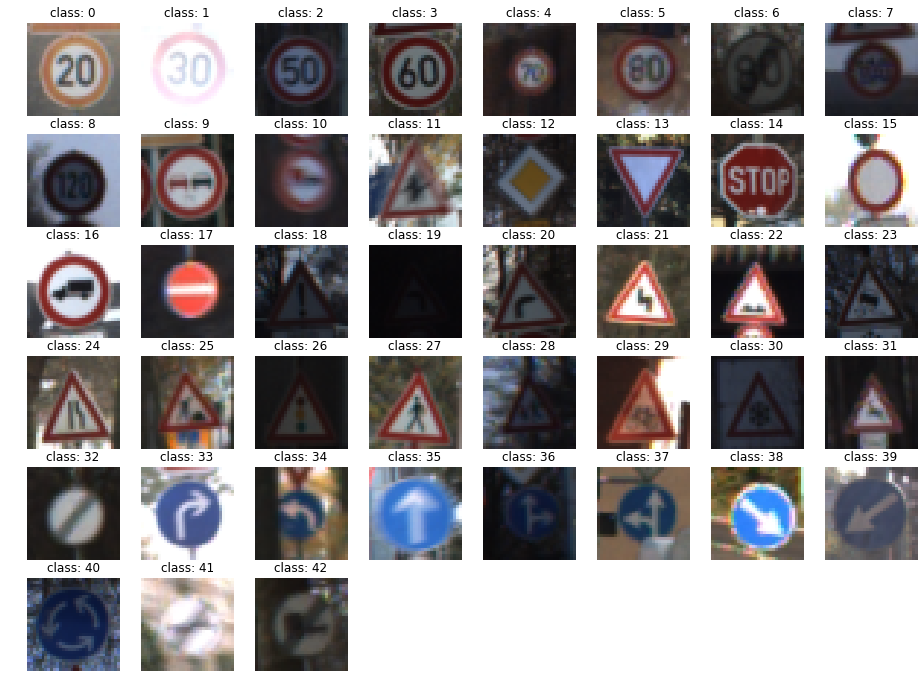

In [39]:
### Data exploration visualization.
fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(train_dataset.labels), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(train_dataset.labels == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(train_dataset.features[i])

In [42]:
model = BaselineNet(gray=True).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

[Epoch 1/20] Train loss: 3.544803	Validation loss: 3.619980	 Validation accruacy: 4.762%
[Epoch 2/20] Train loss: 3.214408	Validation loss: 3.102074	 Validation accruacy: 18.662%
[Epoch 3/20] Train loss: 1.777271	Validation loss: 1.518661	 Validation accruacy: 57.687%
[Epoch 4/20] Train loss: 0.921313	Validation loss: 0.977483	 Validation accruacy: 72.404%
[Epoch 5/20] Train loss: 0.639940	Validation loss: 0.766934	 Validation accruacy: 79.070%
[Epoch 6/20] Train loss: 0.476887	Validation loss: 0.626692	 Validation accruacy: 82.381%
[Epoch 7/20] Train loss: 0.373297	Validation loss: 0.535420	 Validation accruacy: 84.422%
[Epoch 8/20] Train loss: 0.305252	Validation loss: 0.525743	 Validation accruacy: 84.308%
[Epoch 9/20] Train loss: 0.256048	Validation loss: 0.414460	 Validation accruacy: 88.662%
[Epoch 10/20] Train loss: 0.222416	Validation loss: 0.418918	 Validation accruacy: 87.755%
[Epoch 11/20] Train loss: 0.188100	Validation loss: 0.377193	 Validation accruacy: 89.819%
[Epoch 12

### Augmentation

In [138]:
class_sample_count = np.bincount(y_train)
weights = 1 / np.array([class_sample_count[y] for y in y_train])
samp = sampler.WeightedRandomSampler(weights, 43 * 10000)

In [143]:
train_data_transforms = transforms.Compose([
    CLAHE_GRAY(),
    transforms.ToPILImage(),
    transforms.RandomApply([
        transforms.RandomRotation(20, resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, translate=(0.2, 0.2), resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, shear=20, resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, scale=(0.8, 1.2), resample=PIL.Image.BICUBIC)
    ]),
    transforms.ToTensor()
])
test_data_transforms = transforms.Compose([
    CLAHE_GRAY(),
    transforms.ToTensor()
])

train_dataset = PickledDataset(training_file, transform=train_data_transforms)
valid_dataset = PickledDataset(validation_file, transform=test_data_transforms)
test_dataset = PickledDataset(testing_file, transform=test_data_transforms)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, sampler=samp, num_workers=4), preprocess)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=4), preprocess)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4), preprocess)

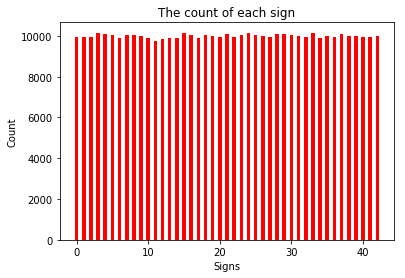

In [137]:
balanced_y_train = torch.LongTensor([]).to(device)

with torch.no_grad():
    for _, y in train_loader:
        balanced_y_train = torch.cat((balanced_y_train, y))

fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(balanced_y_train.cpu().numpy()), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

In [140]:
def convert_image_np(img):
    img = img.numpy().transpose((1, 2, 0)).squeeze()
    mean = 0.4715
    std = 0.2415
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

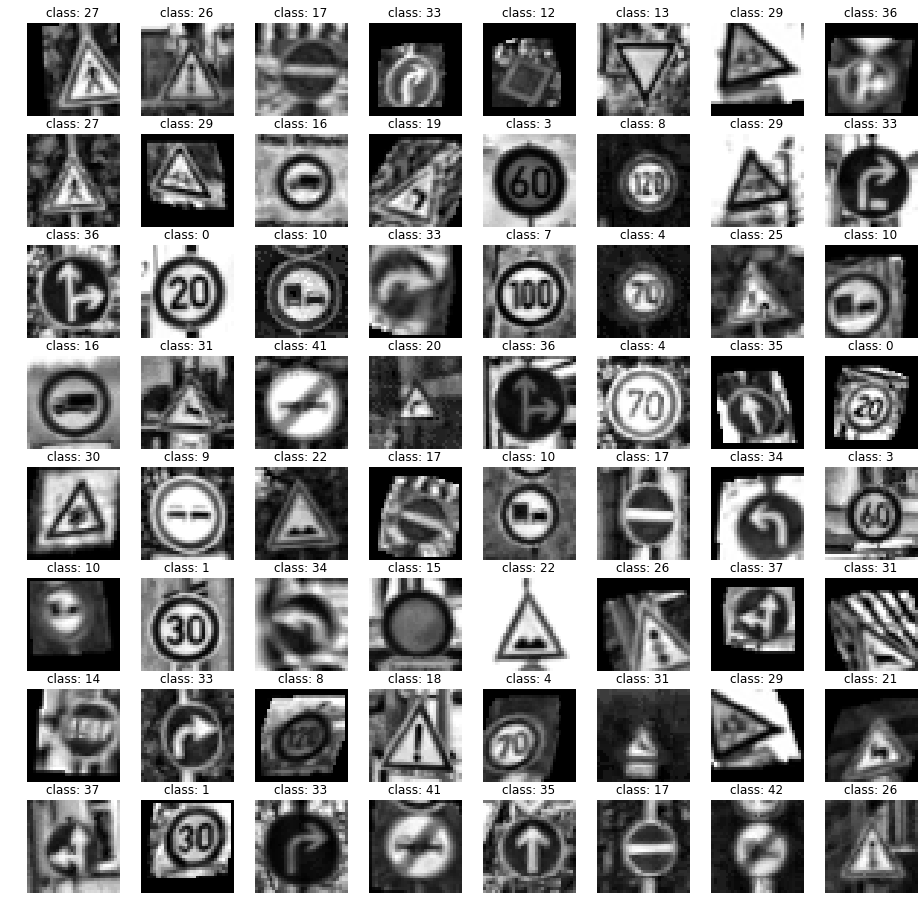

In [141]:
with torch.no_grad():
    x, y = next(iter(train_loader))
    plt.figure(figsize=(16, 16))
    for i in range(len(y)):
        plt.subplot(8, 8, i+1)
        plt.axis('off')
        plt.title('class: {}'.format(y[i]))
        plt.imshow(convert_image_np(x[i].cpu()), cmap='gray')

In [144]:
model = BaselineNet(gray=True).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

[Epoch 1/20] Train loss: 3.666958	Validation loss: 2.611109	 Validation accruacy: 31.610%
[Epoch 2/20] Train loss: 1.791653	Validation loss: 0.637126	 Validation accruacy: 80.952%
[Epoch 3/20] Train loss: 0.889396	Validation loss: 0.483445	 Validation accruacy: 85.669%
[Epoch 4/20] Train loss: 0.634244	Validation loss: 0.417904	 Validation accruacy: 88.367%
[Epoch 5/20] Train loss: 0.509679	Validation loss: 0.407144	 Validation accruacy: 88.639%
[Epoch 6/20] Train loss: 0.436151	Validation loss: 0.325778	 Validation accruacy: 90.884%
[Epoch 7/20] Train loss: 0.387691	Validation loss: 0.345494	 Validation accruacy: 91.293%
[Epoch 8/20] Train loss: 0.352700	Validation loss: 0.317955	 Validation accruacy: 91.088%
[Epoch 9/20] Train loss: 0.320870	Validation loss: 0.318575	 Validation accruacy: 91.587%
[Epoch 10/20] Train loss: 0.298621	Validation loss: 0.325567	 Validation accruacy: 91.701%
[Epoch 11/20] Train loss: 0.282741	Validation loss: 0.300571	 Validation accruacy: 91.746%
[Epoch 1

KeyboardInterrupt: 

### Image normalize

In [ ]:
# Channel separation
red_chan = np.reshape(X_train[:,:,:,0], -1)/255
green_chan = np.reshape(X_train[:,:,:,1], -1)/255
blue_chan = np.reshape(X_train[:,:,:,2], -1)/255

# mean
means = [np.mean(red_chan), np.mean(green_chan), np.mean(blue_chan)]

# std
stds = [np.std(red_chan), np.std(green_chan), np.std(blue_chan)]

print(means)
print(stds)

In [ ]:
# Add normalize
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.3340, 0.3117, 0.3209), (0.2717, 0.2599, 0.2658))
])

train_dataset = PickledDataset(training_file, transform=data_transforms)
valid_dataset = PickledDataset(validation_file, transform=data_transforms)
test_dataset = PickledDataset(testing_file, transform=data_transforms)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), preprocess)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), preprocess)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), preprocess)

In [ ]:
model = BaselineNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

### Contrast-limited adaptive histogram equalization

In [ ]:
class CLAHE:
    def __init__(self, clipLimit=2.0, tileGridSize=(8, 8)):
        self.clipLimit = clipLimit
        self.tileGridSize = tileGridSize

    def __call__(self, im):
        img_yuv = cv2.cvtColor(im, cv2.COLOR_RGB2YUV)
        clahe = cv2.createCLAHE(clipLimit=self.clipLimit, tileGridSize=self.tileGridSize)
        img_yuv[:, :, 0] = clahe.apply(img_yuv[:, :, 0])
        img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
        return img_output
    
class CLAHE_RGB:
    def __init__(self, clipLimit=2.0, tileGridSize=(8, 8)):
        self.clipLimit = clipLimit
        self.tileGridSize = tileGridSize
        
    def __call__(self, im):
        r,g,b = cv2.split(im)
        clahe = cv2.createCLAHE(clipLimit=self.clipLimit, tileGridSize=self.tileGridSize)
        r,g,b = clahe.apply(r), clahe.apply(g), clahe.apply(b)
        return cv2.merge([r,g,b])

In [ ]:
clahe = CLAHE()
plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(clahe(X_train[i]))

In [ ]:
# Apply CLAHE
X_train_clahe = np.array([clahe(x) for x in X_train])

# Channel separation
red_chan = np.reshape(X_train_clahe[:,:,:,0], -1)/255
green_chan = np.reshape(X_train_clahe[:,:,:,1], -1)/255
blue_chan = np.reshape(X_train_clahe[:,:,:,2], -1)/255

# mean
means = [np.mean(red_chan), np.mean(green_chan), np.mean(blue_chan)]

# std
stds = [np.std(red_chan), np.std(green_chan), np.std(blue_chan)]

print(means)
print(stds)

In [ ]:
data_transforms = transforms.Compose([
    CLAHE(),
    transforms.ToTensor(),
    transforms.Normalize((0.4898, 0.4619, 0.4708), (0.2476, 0.2441, 0.2514))
])

train_dataset = PickledDataset(training_file, transform=data_transforms)
valid_dataset = PickledDataset(validation_file, transform=data_transforms)
test_dataset = PickledDataset(testing_file, transform=data_transforms)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), preprocess)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), preprocess)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), preprocess)

In [ ]:
model = BaselineNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

In [ ]:
clahe = CLAHE_RGB()
plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(clahe(X_train[i]))

In [ ]:
# Apply CLAHE
X_train_clahe = np.array([clahe(x) for x in X_train])

# Channel separation
red_chan = np.reshape(X_train_clahe[:,:,:,0], -1)/255
green_chan = np.reshape(X_train_clahe[:,:,:,1], -1)/255
blue_chan = np.reshape(X_train_clahe[:,:,:,2], -1)/255

# mean
means = [np.mean(red_chan), np.mean(green_chan), np.mean(blue_chan)]

# std
stds = [np.std(red_chan), np.std(green_chan), np.std(blue_chan)]

print(means)
print(stds)

In [ ]:
data_transforms = transforms.Compose([
    CLAHE_RGB(),
    transforms.ToTensor(),
    transforms.Normalize((0.4821, 0.4713, 0.4801), (0.2411, 0.2443, 0.2438))
])

train_dataset = PickledDataset(training_file, transform=data_transforms)
valid_dataset = PickledDataset(validation_file, transform=data_transforms)
test_dataset = PickledDataset(testing_file, transform=data_transforms)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), preprocess)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), preprocess)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), preprocess)

In [ ]:
model = BaselineNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

### Grayscale

In [ ]:
class CLAHE_GRAY:
    def __init__(self, clipLimit=2.0, tileGridSize=(8, 8)):
        self.clipLimit = clipLimit
        self.tileGridSize = tileGridSize

    def __call__(self, im):
        img_y = cv2.cvtColor(im, cv2.COLOR_RGB2YUV)[:,:,0]
        clahe = cv2.createCLAHE(clipLimit=self.clipLimit, tileGridSize=self.tileGridSize)
        img_y = clahe.apply(img_y)
        img_output = img_y.reshape(img_y.shape + (1,))
        return img_output

In [ ]:
clahe = CLAHE_GRAY()
plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(clahe(X_train[i]).squeeze(), cmap='gray')

In [ ]:
# Apply CLAHE
X_train_clahe = np.array([clahe(x) for x in X_train])

gray_chan = np.reshape(X_train_clahe[:,:,:,0], -1)/255
print(np.mean(gray_chan))
print(np.std(gray_chan))

In [ ]:
data_transforms = transforms.Compose([
    CLAHE_GRAY(),
    transforms.ToTensor(),
    transforms.Normalize((0.4715,),(0.2415,))
])

train_dataset = PickledDataset(training_file, transform=data_transforms)
valid_dataset = PickledDataset(validation_file, transform=data_transforms)
test_dataset = PickledDataset(testing_file, transform=data_transforms)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), preprocess)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), preprocess)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), preprocess)

In [ ]:
model = BaselineNet(gray=True).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

## Handling imbalanced dataset

In [ ]:
# Use weighted sampler
class_sample_count = np.bincount(y_train)
weights = 1 / np.array([class_sample_count[y] for y in y_train])
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, 43 * 5000)

In [ ]:
class_sample_count = np.bincount(y_train)
weights = 1 / np.array([class_sample_count[y] for y in y_train])
sampler = torch.utils.data.sampler.BatchSampler(torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights)), 64, False)

In [ ]:
# Data augmentation
train_data_transforms = transforms.Compose([
    CLAHE_GRAY(),
    transforms.ToPILImage(),
    transforms.RandomApply([
        transforms.RandomRotation(20, resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, translate=(0.2, 0.2), resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, shear=20, resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, scale=(0.8, 1.2), resample=PIL.Image.BICUBIC)
    ]),
    transforms.ToTensor(),
    transforms.Normalize((0.4715,),(0.2415,))
])
test_data_transforms = transforms.Compose([
    CLAHE_GRAY(),
    transforms.ToTensor(),
    transforms.Normalize((0.4715,),(0.2415,))
])

train_dataset = PickledDataset(training_file, transform=train_data_transforms)
valid_dataset = PickledDataset(validation_file, transform=test_data_transforms)
test_dataset = PickledDataset(testing_file, transform=test_data_transforms)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_sampler=sampler), preprocess)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), preprocess)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), preprocess)

In [ ]:
balacned_y_train = np.array([], dtype=np.int64)

with torch.no_grad():
    for _, y in train_loader:
        balacned_y_train = np.append(balacned_y_train, y.cpu().numpy())

fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(balacned_y_train), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

In [ ]:
def convert_image_np(img):
    img = img.numpy().transpose((1, 2, 0)).squeeze()
    mean = 0.4715
    std = 0.2415
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

with torch.no_grad():
    x, y = next(iter(train_loader))
    plt.figure(figsize=(16, 16))
    for i in range(len(y)):
        plt.subplot(8, 8, i+1)
        plt.axis('off')
        plt.title('class: {}'.format(y[i]))
        plt.imshow(convert_image_np(x[i].cpu()), cmap='gray')

In [ ]:
model = BaselineNet(gray=True).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

## Batch normalization, Dropout, Early stopping

In [ ]:
class TrafficSignNet(nn.Module):
    def __init__(self):
        super(TrafficSignNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 100, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(100, 150, 3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(150)
        self.conv3 = nn.Conv2d(150, 250, 2, padding=1)
        self.fc1 = nn.Linear(250 * 4 * 4, 300)
        self.fc1_bn = nn.BatchNorm1d(300)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(300, 43)

    def forward(self, x):
        x = self.pool(F.elu(self.conv1(x)))
        x = self.pool(F.elu(self.conv2_bn(self.conv2(x))))
        x = self.pool(F.elu(self.conv3(x)))
        x = x.view(-1, 250 * 4 * 4)
        x = F.elu(self.fc1_bn(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    valid_loss_min = np.Inf
    for epoch in range(epochs):
        # Train model
        model.train()
        losses, nums = zip(*[loss_batch(model, loss_func, x, y, opt) for x, y in train_dl])
        train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        # Validation model
        model.eval()
        with torch.no_grad():
            losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in valid_dl])
            valid_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            valid_accuracy = np.sum(corrects) / np.sum(nums) * 100
            print(f"[Epoch {epoch+1}/{epochs}] "
                  f"Train loss: {train_loss:.6f}\t"
                  f"Validation loss: {valid_loss:.6f}\t",
                  f"Validation accruacy: {valid_accuracy:.3f}%")
            # save model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                print(f"Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...")
                torch.save(model.state_dict(), 'model.pt')
                valid_loss_min = valid_loss

In [ ]:
model = TrafficSignNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)

In [ ]:
check_point = torch.load('model.pt', map_location=device)
model.load_state_dict(check_point)
evaluate(model, criterion, test_loader)

# Spatial transformer networks

In [ ]:
class StnNet(nn.Module):
    def __init__(self):
        super(StnNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 100, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(100, 150, kernel_size=3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(150)
        self.conv3 = nn.Conv2d(150, 250, kernel_size=2, padding=1)
        self.fc1 = nn.Linear(250 * 4 * 4, 300)
        self.fc1_bn = nn.BatchNorm1d(300)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(300, 43)
        
        # Spatial transformer localization-network
        self.loc_net = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )
        
        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 4 * 4, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        
        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        
    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.loc_net(x)
        xs = xs.view(-1, 10 * 4 * 4)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        x = self.stn(x)
        x = self.pool(F.elu(self.conv1(x)))
        x = self.pool(F.elu(self.conv2_bn(self.conv2(x))))
        x = self.pool(F.elu(self.conv3(x)))
        x = x.view(-1, 250 * 4 * 4)
        x = F.elu(self.fc1_bn(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
model = StnNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)

## Visualizing the STN results

In [ ]:
def visualize_stn():
    with torch.no_grad():
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_tensor = model.stn(data).cpu()

        input_grid = convert_image_np(make_grid(input_tensor))
        transformed_grid = convert_image_np(make_grid(transformed_tensor))

        # Plot the results side-by-side
        fig, ax = plt.subplots(1, 2)
        fig.set_size_inches((16, 16))
        ax[0].imshow(input_grid)
        ax[0].set_title('Dataset Images')
        ax[0].axis('off')

        ax[1].imshow(transformed_grid)
        ax[1].set_title('Transformed Images')
        ax[1].axis('off')
        
visualize_stn()